# pyBKT Model Tutorial

This is a tutorial that explores the basic features of pyBKT, ranging from model creation, fitting, prediction, evaluation and crossvalidation. We will be using the skills contained within the Cognitive Tutor and 2009-2010 Assistments datasets to demonstrate these features.

In [1]:
# More comprehensive patch - run this FIRST before any imports
import sys
import types

# Create a custom random module that patches at import time
original_random = __import__('random')

class PatchedRandom:
    def __init__(self):
        # Copy all attributes from original random
        for attr in dir(original_random):
            if not attr.startswith('_'):
                setattr(self, attr, getattr(original_random, attr))

    def randrange(self, start, stop=None, step=1):
        """Patched randrange that handles floats"""
        if stop is None:
            return original_random.randrange(int(start))
        else:
            return original_random.randrange(int(start), int(stop), int(step))

# Replace random in sys.modules before any other imports
sys.modules['random'] = PatchedRandom()

# Now try importing pyBKT
try:
    import pandas as pd
    import numpy as np
    from pyBKT.models import Model
    import matplotlib.pyplot as plt
    print("✅ pyBKT imported successfully with aggressive patch!")
except Exception as e:
    print(f"❌ Still failed: {e}")

❌ Still failed: No module named 'pyBKT'


In [1]:
# Fix for Python 3.12 compatibility
import random
import numpy as np

# Store the original randrange function
_original_randrange = random.randrange

def _patched_randrange(start, stop=None, step=1):
    """Patch randrange to handle float inputs"""
    if stop is None:
        return _original_randrange(int(start))
    else:
        return _original_randrange(int(start), int(stop), int(step))

# Apply the patch
random.randrange = _patched_randrange


In [2]:
# Install pyBKT from pip!
!pip install pyBKT

# Import all required packages including pyBKT.models.Model!
from pyBKT.models import Model
import matplotlib.pyplot as plt

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 32.8/32.8 MB 51.0 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for pyBKT: filename=pyBKT-1.4.1-cp312-cp312-linux_x86_64.whl size=1130213 sha256=d6c5dc266b2ed8042fcbddfec36007de077bd86443ed8ee7736be54ac020b348
  Stored in directory: /root/.cache/pip/wheels/5a/88/7a/78084727bcce075a111f6e5557349e3c4d99ad3b294b473a32
Successfully built pyBKT


TypeError: 'float' object cannot be interpreted as an integer

### Basic Model Creation and Evaluation

Initialize the model with an optional seed and number of fit initializations. Note that the Model constructor supports many more parameters such as the model variant (which can be modified at fit time), whether to parallelize computation, and more.

In [ ]:
# Note that the seed chosen is so we can consistently
# replicate the results and avoid as much randomness
# as possible.
model = Model(seed = 42, num_fits = 1)

Fetch Assistments and CognitiveTutor data to the local disk. We will be using these datasets, but you can use any that you see fit when you use pyBKT. The data formats accepted by pyBKT are comma separated and tab separated files (note that pyBKT will automatically infer which is passed in). Note that the correctness is given by -1 (no response), 0 (incorrect), or 1 (correct).

In [ ]:
model.fetch_dataset('https://raw.githubusercontent.com/CAHLR/pyBKT-examples/master/data/as.csv', '.')
model.fetch_dataset('https://raw.githubusercontent.com/CAHLR/pyBKT-examples/master/data/ct.csv', '.')

We open the given datasets and explore them before using them to fit BKT models using pyBKT. Note that the column names describing the student ID, the problem name, the response's correctness and skill name all differ between the two datasets.

In [ ]:
ct_df = pd.read_csv('ct.csv', encoding = 'latin')
print(ct_df.columns)
ct_df.head(5)

Index(['Unnamed: 0', 'Row', 'Anon Student Id', 'Problem Hierarchy',
       'Problem Name', 'Problem View', 'Step Name', 'Step Start Time',
       'First Transaction Time', 'Correct Transaction Time', 'Step End Time',
       'Step Duration (sec)', 'Correct Step Duration (sec)',
       'Error Step Duration (sec)', 'Correct First Attempt', 'Incorrects',
       'Hints', 'Corrects', 'KC(Default)', 'Opportunity(Default)'],
      dtype='object')


,Unnamed: 0,Row,Anon Student Id,Problem Hierarchy,Problem Name,Problem View,Step Name,Step Start Time,First Transaction Time,Correct Transaction Time,Step End Time,Step Duration (sec),Correct Step Duration (sec),Error Step Duration (sec),Correct First Attempt,Incorrects,Hints,Corrects,KC(Default),Opportunity(Default)
0,1576,1927,745Yh,"Unit RATIO-PROPORTION, Section RATIO-PROPORTION-2",RATIO2-001,1,SimplifiedNumeratorQuantity1,2006-11-14 10:18:00.0,2006-11-14 10:18:05.0,2006-11-14 10:18:05.0,2006-11-14 10:18:05.0,5.00000,5.00000,NaN,1,0,0,1,Calculate unit rate,1
1,1580,1931,745Yh,"Unit RATIO-PROPORTION, Section RATIO-PROPORTION-2",RATIO2-001,1,SimplifiedNumeratorQuantity2,2006-11-14 10:18:11.0,2006-11-14 10:18:17.0,2006-11-14 10:18:34.0,2006-11-14 10:18:34.0,23.00000,NaN,23.00000,0,1,0,1,Calculate unit rate,2
2,1596,1947,745Yh,"Unit RATIO-PROPORTION, Section RATIO-PROPORTION-2",RATIO2-012,1,SimplifiedNumeratorQuantity1,2006-11-14 10:50:52.0,2006-11-14 10:50:57.0,2006-11-14 10:51:11.0,2006-11-14 10:51:11.0,18.00000,NaN,18.00000,0,1,0,1,Calculate unit rate,3
3,1597,1948,745Yh,"Unit RATIO-PROPORTION, Section RATIO-PROPORTION-2",RATIO2-012,1,SimplifiedNumeratorQuantity2,2006-11-14 10:51:11.0,2006-11-14 10:51:14.0,2006-11-14 10:51:14.0,2006-11-14 10:51:14.0,3.00000,3.00000,NaN,1,0,0,1,Calculate unit rate,4
4,1612,1963,745Yh,"Unit RATIO-PROPORTION, Section RATIO-PROPORTION-2",RATIO2-054,1,SimplifiedNumeratorQuantity2,2006-11-28 09:53:43.0,2006-11-28 09:53:47.0,2006-11-28 09:53:56.0,2006-11-28 09:53:56.0,13.00000,NaN,13.00000,0,1,0,1,Calculate unit rate,5


In [ ]:
as_df = pd.read_csv('as.csv', encoding = 'latin', low_memory = False)
print(as_df.columns)
as_df.head(5)

Index(['order_id', 'assignment_id', 'user_id', 'assistment_id', 'problem_id',
       'original', 'correct', 'attempt_count', 'ms_first_response',
       'tutor_mode', 'answer_type', 'sequence_id', 'student_class_id',
       'position', 'type', 'base_sequence_id', 'skill_id', 'skill_name',
       'teacher_id', 'school_id', 'hint_count', 'hint_total', 'overlap_time',
       'template_id', 'answer_id', 'answer_text', 'first_action',
       'bottom_hint', 'opportunity', 'opportunity_original'],
      dtype='object')


,order_id,assignment_id,user_id,assistment_id,problem_id,original,correct,attempt_count,ms_first_response,tutor_mode,...,hint_count,hint_total,overlap_time,template_id,answer_id,answer_text,first_action,bottom_hint,opportunity,opportunity_original
0,33022537,277618,64525,33139,51424,1,1,1,32454,tutor,...,0,3,32454,30799,NaN,26,0,NaN,1,1.00000
1,33022709,277618,64525,33150,51435,1,1,1,4922,tutor,...,0,3,4922,30799,NaN,55,0,NaN,2,2.00000
2,35450204,220674,70363,33159,51444,1,0,2,25390,tutor,...,0,3,42000,30799,NaN,88,0,NaN,1,1.00000
3,35450295,220674,70363,33110,51395,1,1,1,4859,tutor,...,0,3,4859,30059,NaN,41,0,NaN,2,2.00000
4,35450311,220674,70363,33196,51481,1,0,14,19813,tutor,...,3,4,124564,30060,NaN,65,0,0.00000,3,3.00000


We can fit a simple BKT model with the `fit` method for the Model class. In this case, we will fit a BKT model to every skill in the Cognitive Tutor dataset separately. Note that when skill(s) are not specified, it trains a separate model on all skills by default.

We can either specify a data path (location of a file) or the Pandas DataFrame containing the data.

In [ ]:
model.fit(data_path = 'ct.csv')

We can train on multiple skills specified by a list of skill names or a
REGEX match for each skill using the `skills` parameter. We demonstrate the usage of that below. In this case, we fit on all strings containing fraction.

In [ ]:
model.fit(data_path = 'ct.csv', skills = ".*fraction.*")
print("Fitted Skills:\n%s" % '\n'.join(model.coef_.keys()))

Fitted Skills:
Plot non-terminating improper fraction
Plot terminating proper fraction
Calculate part in proportion with fractions
Calculate total in proportion with fractions


Evaluate on the trained skills for any test data located in a Pandas DataFrame or in a file. In this case, we will just use training data, so this will display the training error. Note that the default metric displayed is RMSE. pyBKT supports AUC, RMSE, and accuracy
as metrics by default.

However, you can define your own custom metric as well!

In [ ]:
# Evaluate with the default RMSE then specify AUC.
model.fit(data_path = 'ct.csv')
training_rmse = model.evaluate(data = ct_df)
training_auc = model.evaluate(data_path = "ct.csv", metric = 'auc')
print("Training RMSE: %f" % training_rmse)
print("Training AUC: %f" % training_auc)

Training RMSE: 0.454043
Training AUC: 0.705992


In [ ]:
# We can even define our own metric!
def mae(true_vals, pred_vals):
  """ Calculates the mean absolute error. """
  return np.mean(np.abs(true_vals - pred_vals))

training_mae = model.evaluate(data_path = 'ct.csv', metric = mae)
print("Training MAE: %f" % training_mae)

Training MAE: 0.412439


### Model Prediction

pyBKT can return predictions on a test set given a Pandas DataFrame or a file conaining test data. If pyBKT is asked for predictions on skills for which it has not trained a model, it will output a best effort guess of 0.5 for both the correct and state predictions.

We will be using the training dataset again for testing purposes.

In [ ]:
# Note again that the REGEX expression below trains BKT models on all
# skills containing the word fraction!
model.fit(data_path = 'ct.csv', skills = ".*fraction.*")
preds = model.predict(data_path = 'ct.csv')
preds[['Anon Student Id', 'KC(Default)', 'Correct First Attempt',
       'correct_predictions', 'state_predictions']].head(5)

,Anon Student Id,KC(Default),Correct First Attempt,correct_predictions,state_predictions
773,0I891Gg,Plot non-terminating improper fraction,0,0.52052,0.71971
774,0I891Gg,Plot imperfect radical,0,0.50000,0.50000
775,0I891Gg,Plot terminating proper fraction,0,0.51025,0.40413
776,0I891Gg,Plot pi,1,0.50000,0.50000
777,0I891Gg,Plot terminating proper fraction,1,0.44909,0.25109


In [ ]:
# Let's sanity check that we have only trained on the skills that we
# specified in the call to fit! Note that while it is possible for a
# BKT prediction to be 0.5 exactly, it is unlikely.
preds[preds['correct_predictions'] != 0.5]['KC(Default)'].unique()

array(['Plot non-terminating improper fraction',
       'Plot terminating proper fraction',
       'Calculate part in proportion with fractions',
       'Calculate total in proportion with fractions'], dtype=object)

In [ ]:
# Let's manually calculate the RMSE of the correct predictions
# and ensure that it is the same as a call to the evaluate function.
def rmse(y_true, y_pred):
  """ Returns the root-mean squared error. """
  return np.sqrt(np.mean((y_true - y_pred) ** 2))

# Filter out the data for which we did not train!
preds_filtered = preds[preds['KC(Default)'].str.contains('fraction')]
manual_training_rmse = rmse(preds_filtered['Correct First Attempt'],
                            preds_filtered['correct_predictions'])
manual_training_rmse

0.44074040574478407

In [ ]:
# We use model.evaluate to accomplish the same thing!
# You should receive an RMSE that is identical to the above
# manually calculated RMSE.
model.evaluate(data = ct_df)

0.4407404057447841

### Model Cross-Validation and Variants

Crossvalidation is offered as a blackbox function similar to a combination of fit and evaluate that accepts a particular number of folds, a seed, and a metric (either one of the 3 provided that are 'rmse', 'auc' or 'accuracy' or a custom Python function taking 2 arguments). Similar arguments for the model types, data path/data, and skill names are accepted as with the fit function.

In [ ]:
# Note that folds is an optional parameter as well as the model
# variant, seed, and crossvalidated metric.
# By default, we crossvalidate on all skills separately.
model.crossvalidate(data_path = 'ct.csv', folds = 5)

,rmse
skill,
Plot non-terminating improper fraction,0.48386
Plot imperfect radical,0.43806
Plot terminating proper fraction,0.49791
Plot pi,0.46037
Plot whole number,0.29032
Plot decimal - thousandths,0.47338
Calculate unit rate,0.48287
Calculate part in proportion with fractions,0.42788
Calculate total in proportion with fractions,0.42401


We explore all the model variants offered within pyBKT for one particular skill (Calculations with Similar Figures) using cross-validation since it provides a much better evaluation of true model performance during test time than the training loss!

In [ ]:
# Try this with a different skill or metric by replacing the lines below.
skill = 'Calculations with Similar Figures'
metric = 'auc'

simple_cv = model.crossvalidate(data = as_df, skills = skill,
                                metric = metric)
simple_cv

,auc
skill,
Calculations with Similar Figures,0.60004


The multigs model fits a different guess/slip rate for each class. Note that by default, for the CognitiveTutor data, the guess and slip classes will be specified by the template_id. pyBKT will be able to infer the column names for AS/CT type datasets, but you can specify a custom column mapping (discussed in later cells).

In [ ]:
multigs_cv = model.crossvalidate(data_path = 'as.csv', skills = skill,
                                 multigs = True, metric = metric)
multigs_cv

,auc
skill,
Calculations with Similar Figures,0.63260


The multilearn model fits a different learn rate (and forget rate if enabled) rate for each class specified. Note that the learn classes are specified by the template_id column by default for the Assistments dataset.

In [ ]:
multilearn_cv = model.crossvalidate(data_path = 'as.csv', skills = skill,
                                    multilearn = True, forgets = True,
                                    metric = metric)
multilearn_cv

,auc
skill,
Calculations with Similar Figures,0.58376


The multilearn model fits a different learn (and forget if enabled) rate for each class, and the multipair model generates a different learn rate based on each consecutive pair of classes.

In [ ]:
# The multiprior model generates different priors based on the first
# response of each student.
multiprior_cv = model.crossvalidate(data_path = 'as.csv', skills = skill,
                                    multiprior = True, metric = metric,
                                    folds = 3)
multipair_cv = model.crossvalidate(data_path = 'as.csv', skills = skill,
                                   multipair = True, metric = metric,
                                   folds = 3)
pd.concat([multiprior_cv, multipair_cv], axis = 0)

,auc
skill,
Calculations with Similar Figures,0.60358
Calculations with Similar Figures,0.59404


The best performing models are typically those that combine several useful variants such as the multilearn and multiguess/slip class variants. We will enable the forgets parameter as well. Try testing with other skills and see whether this holds true for the general case.

In [ ]:
# We combine the fifth parameter, forgets, with the previous multilearn
# and multiguess/slip models for a combo model.
combo_cv = model.crossvalidate(data_path = 'as.csv', skills = skill,
                               forgets = True, multilearn = True,
                               multigs = True, metric = metric)
combo_cv

,auc
skill,
Calculations with Similar Figures,0.61089


### Model Parameter Initialization and Visualization

We can initialize any of the model parameters for a particular skill's BKT model before training using `model.coef_`. Similar to SciKit Learn, `model.coef_` is a way to initialize model parameters and view them after they are fitted.


In [ ]:
# We initialize the prior parameter to 1e-3 for the Box and Whisker
# skill.
#
# Note that if we are training a KT-IDEM (multiguess/slip) model,
# we need to have len(guesses) == len(slips) == # of G/S classes.
# Similarly, for multilearn models, you need len(forgets) == len(guesses)
# corresponding to the number of learn classes.
skill = 'Box and Whisker'

model.coef_ = {skill: {'prior': 1e-40}}
model.coef_

{'Box and Whisker': {'prior': 1e-40}}

In [ ]:
# Train the model with the pre-initialized parameters.
model.fit(data_path = 'as.csv', skills = skill, multigs = True)
low_prior_auc = model.evaluate(data_path = 'as.csv', metric = 'auc')

# We can obtain the prior value by indexing into the model.coef_
# dictionary with the skill and parameter names.
print("Fitted Prior Value: %f" % model.coef_[skill]['prior'])
print("Training AUC: %f" % low_prior_auc)

Fitted Prior Value: 0.000000
Training AUC: 0.657672


In [ ]:
# Initialize the prior to be more reasonable.
model.coef_ = {skill: {'prior': 0.5}}
model.fit(data_path = 'as.csv', skills = skill, multigs = True)
normal_prior_auc = model.evaluate(data_path = 'as.csv', metric = 'auc')

# Print the fitted prior value and RMSE.
print("Fitted Prior Value: %f" % model.coef_[skill]['prior'])
print("Training AUC: %f" % normal_prior_auc)

Fitted Prior Value: 0.004567
Training AUC: 0.636100


We can visualize the parameters of our fitted model in a Pandas DataFrame once it has been fit. We can easily plot the learn, forget, guess, and slip rates for multilearn/forget and multiguess/slip models.

In [ ]:
model.fit(data_path = 'as.csv', skills = skill,
          forgets = True, multilearn = True,
          multigs = True)
model.params()

value
skill           param   class          
Box and Whisker prior   default 0.64820
                learns  30059   0.56359
                        30060   0.60397
                        30799   0.50706
                        63446   0.56288
                        63447   0.52897
                        63448   0.47822
                guesses 30059   0.13408
                        30060   0.06972
                        30799   0.07577
                        63446   0.09770
                        63447   0.04246
                        63448   0.11546
                slips   30059   0.01453
                        30060   0.04001
                        30799   0.02174
                        63446   0.03091
                        63447   0.04750
                        63448   0.02369
                forgets 30059   0.15937
                        30060   0.14845
                        30799   0.12853
                        63446   0.17640
                        63447   0.15751
                        63448   0.23968

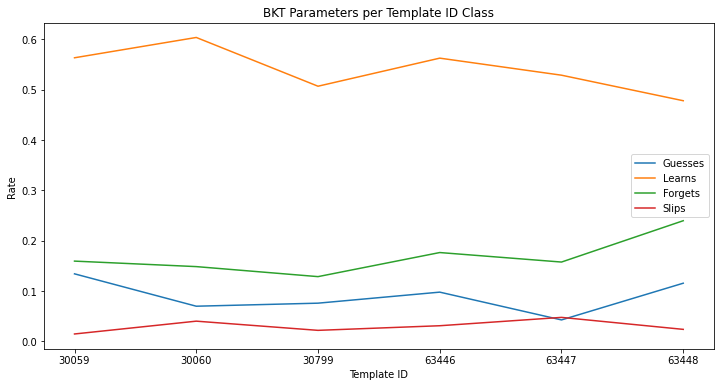

In [ ]:
# We will get warnings for using indexing past lexsort. That's fine,
# and we will disable these warnings.
import warnings
warnings.simplefilter(action='ignore')

# Plot the learns, forgets, slips and guesses for each of the classes.
params = model.params()
plt.figure(figsize = (12, 6))
plt.plot(params.loc[(skill, 'guesses')], label = 'Guesses')
plt.plot(params.loc[(skill, 'learns')], label = 'Learns')
plt.plot(params.loc[(skill, 'forgets')], label = 'Forgets')
plt.plot(params.loc[(skill, 'slips')], label = 'Slips')
plt.xlabel('Template ID')
plt.ylabel('Rate')
plt.title('BKT Parameters per Template ID Class')
plt.legend();

### Extended Data and Model Configuration

Models can get excessively long, whether it's due to the number of model variants used, the number of folds/seed/metric for crossvalidation, data path length, etc.

We create a configuration dictionary that describes all the parameters we will pass in. Note that this is not a pyBKT feature, but actually just a Python feature that not many realize is very powerful!

In [ ]:
config = {'multigs': True,
          'multilearn': True,
          'skills': ['Box and Whisker', 'Circle Graph'],
          'forgets': True,
          'metric': 'accuracy',
          'folds': 4,
          'seed': 42 * 42}
model.crossvalidate(data_path = 'as.csv', **config)

,accuracy
skill,
Circle Graph,0.67644
Box and Whisker,0.75666


For other non-Assistments/CogTutor style datasets, we will need to specify the
columns corresponding to each required column (i.e. the user ID, correct/incorrect). This is because pyBKT only supports the automatic inference of column names for the AS/CT datasets.

For that, we use a defaults dictionary or specify parameters for each model variant.

In [ ]:
# Note that this means that the order_id specified by the column named
# custom_order in our custom dataset, the skill_name is specified by the
# custom_skill column in our custom dataset, and so on.
defaults = {'order_id': 'custom_order',
            'skill_name': 'custom_skill',
            'correct': 'custom_answer'}

# This defaults dictionary can also contain columns specifying
# what columns correspond to the desired guess/slip classes, etc.
defaults['multigs'] = 'custom_gs_classes'

# Our final column mapping is:
defaults

{'correct': 'custom_answer',
 'multigs': 'custom_gs_classes',
 'order_id': 'custom_order',
 'skill_name': 'custom_skill'}

In [ ]:
# We'll use this mapping with the modified CogTutor dataset with the names
# we chose for the columns.
#
# Note that Row is the order ID (order_id), KC(Default) is the
# skill name (skill_name), Correct First Attempt is correct, and
# Problem Name is the corresponding guess/slip class column.

columns = ['Row', 'Anon Student Id', 'KC(Default)',
           'Correct First Attempt', 'Problem Name']
my_df = ct_df[columns]
my_df.columns = ['custom_order', 'Anon Student Id',
                 'custom_skill', 'custom_answer',
                 'custom_gs_classes']
my_df['custom_skill'] += ' (Custom)'
my_df.head(5)

,custom_order,Anon Student Id,custom_skill,custom_answer,custom_gs_classes
773,112149,0I891Gg,Plot non-terminating improper fraction (Custom),0,RATIONAL1-014
774,112151,0I891Gg,Plot imperfect radical (Custom),0,RATIONAL1-041
775,112156,0I891Gg,Plot terminating proper fraction (Custom),0,RATIONAL1-104
776,112157,0I891Gg,Plot pi (Custom),1,RATIONAL1-122
777,112159,0I891Gg,Plot terminating proper fraction (Custom),1,RATIONAL1-180


In [ ]:
# We can crossvalidate/fit given these default column mappings.
model.crossvalidate(data = my_df, metric = 'auc',
                    defaults = defaults)

,auc
skill,
Plot non-terminating improper fraction (Custom),0.64623
Plot imperfect radical (Custom),0.64343
Plot terminating proper fraction (Custom),0.56619
Plot pi (Custom),0.57295
Plot whole number (Custom),0.55110
Plot decimal - thousandths (Custom),0.62797
Calculate unit rate (Custom),0.59025
Calculate part in proportion with fractions (Custom),0.67440
Calculate total in proportion with fractions (Custom),0.70752


### Sample Case Studies

In [ ]:
# Question 1: Which model variant has the smallest training loss for
# "Venn Diagram" in as.csv?
models = {}

model = Model(seed = 42, num_fits = 1)
model.fit(data_path="as.csv", skills="Venn Diagram")
models['simple'] = model.evaluate(data_path="as.csv")
model.fit(data_path="as.csv", skills="Venn Diagram", multilearn=True)
models['multilearn'] = model.evaluate(data_path="as.csv")
model.fit(data_path="as.csv", skills="Venn Diagram", multigs=True)
models['multigs'] = model.evaluate(data_path="as.csv")
model.fit(data_path="as.csv", skills="Venn Diagram", forgets=True)
models['forgets'] = model.evaluate(data_path="as.csv")
model.fit(data_path="as.csv", skills="Venn Diagram", forgets=True,
          multigs = True)
models['multigs + forgets'] = model.evaluate(data_path="as.csv")
model.fit(data_path="as.csv", skills="Venn Diagram", forgets=True,
          multilearn = True)
models['multilearn + forgets'] = model.evaluate(data_path="as.csv")

df = pd.DataFrame(models.items())
df.columns = ['model type', 'RMSE']
df.set_index('model type')

,RMSE
model type,
simple,0.33123
multilearn,0.32946
multigs,0.33993
forgets,0.27888
multigs + forgets,0.26908
multilearn + forgets,0.26900


In [ ]:
# Question 2: Which columns work the best for the multilearn skills
# below in ct.csv?

skills = ['Calculate unit rate',
          'Calculate part in proportion with fractions']
column_names = ["Anon Student Id", "Problem Hierarchy", "Problem Name",
                "Problem View", "Step Name", "Correct First Attempt",
                "Incorrects", "Hints", "Opportunity(Default)"]
model = Model(num_fits = 1)
for skill in skills:
  print("------------------")
  print("SKILL: %s" % skill)
  print("Basic:", model.crossvalidate(data_path="ct.csv",
                                    skills=skill,
                                    metric = 'auc').iloc[0, 0])
  for i in column_names:
    print("%s:" % i, model.crossvalidate(data_path="ct.csv",
                                              skills=skill,
                                              multilearn=i,
                                              metric = 'auc').iloc[0, 0])

------------------
SKILL: Calculate unit rate
Basic: 0.5703088403461126
Anon Student Id: 0.4712113751950716
Problem Hierarchy: 0.5938492821531571
Problem Name: 0.5722995156825993
Problem View: 0.6004694118557877
Step Name: 0.5933245970640565
Correct First Attempt: 0.5961962821574913
Incorrects: 0.5941812246320743
Hints: 0.5770109757243184
Opportunity(Default): 0.5600904334785606
------------------
SKILL: Calculate part in proportion with fractions
Basic: 0.6741835631572972
Anon Student Id: 0.5094491854820841
Problem Hierarchy: 0.6745728043068085
Problem Name: 0.6733115664800635
Problem View: 0.6735468632272112
Step Name: 0.6748477766476226
Correct First Attempt: 0.6755843591362207
Incorrects: 0.6740718583979385
Hints: 0.6791906668083765
Opportunity(Default): 0.6751418065539259


RMSE Improvement using Resp. Time: 0.000638


,mean learn rate
class,
less than 10s,0.12688
less than 20s,0.19353
less than 30s,0.19767
less than 40s,0.16675
less than 50s,0.18148
other,0.18809


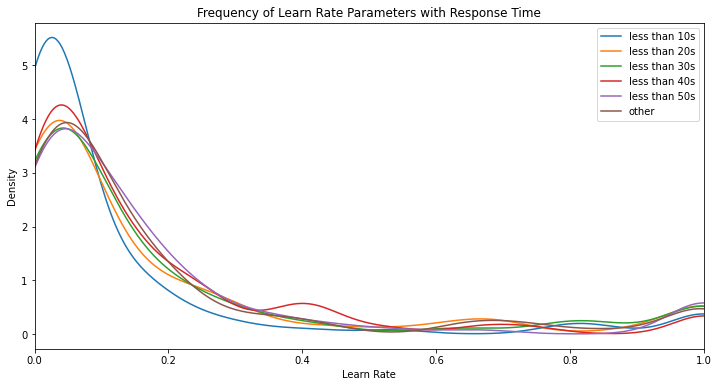

In [ ]:
# Question 3: Does binned response time have an effect on the learn rate?
# Does it improve the RMSE of the model compared to the normal template_id
# based multilearn/guess?

as_df = pd.read_csv('as.csv', encoding = 'latin')
learn_maps = {0: 'less than 10s',
              1: 'less than 20s',
              2: 'less than 30s',
              3: 'less than 40s',
              4: 'less than 50s'}
as_df['resp_t'] = (as_df['ms_first_response'] // 10000) \
                  .map(learn_maps).fillna('other')
model.fit(data = as_df, multilearn = 'resp_t')
params_df = model.params().reset_index()
plt.figure(figsize = (12, 6))
params_df[params_df['param'] == 'learns'].groupby('class')['value'] \
                                         .plot.kde(bw_method=0.2)
plt.xlim((0, 1))
plt.legend()
plt.title('Frequency of Learn Rate Parameters with Response Time')
plt.xlabel('Learn Rate')

simple_rmse = model.crossvalidate(data = as_df)
resptime_combo_rmse = model.crossvalidate(data = as_df,
                                              multigs = 'resp_t',
                                              multilearn = 'resp_t')
normal_combo_rmse = model.crossvalidate(data = as_df,
                                        multigs = True,
                                        multilearn = True)
rmse_diff = (resptime_combo_rmse - normal_combo_rmse)['rmse'].mean()
print("RMSE Improvement using Resp. Time: %f" % rmse_diff)
params_df[params_df['param'] == 'learns'].groupby('class') \
                                         .mean()[['value']] \
                                         .rename(columns = {'value':
                                                  'mean learn rate'})

### Summary

The following is a summary of most of the key features of BKT.

In [ ]:
# Let's summarize.
def mae(true_vals, pred_vals):
  """ Calculates the mean absolute error. """
  return np.mean(np.abs(true_vals - pred_vals))

# This code fetches data, fits, predicts, evaluates and crossvalidates
# a BKT model on all skills in Cognitive Tutor. It uses the mean absolute
# error as the desired error metric.
model = Model(seed = 42, num_fits = 5)
model.fit(data_path = 'ct.csv')
preds_df = model.predict(data_path = 'ct.csv')
mae_error = model.evaluate(data_path = 'ct.csv', metric = mae)
cv_errors = model.crossvalidate(data_path = 'ct.csv', metric = mae)
model.fit(data_path = 'ct.csv')
params_df = model.params()
print("Training MAE: %f" % mae_error)
cv_errors

Training MAE: 0.412533


,mae
skill,
Plot non-terminating improper fraction,0.46886
Plot imperfect radical,0.38154
Plot terminating proper fraction,0.49254
Plot pi,0.42567
Plot whole number,0.16942
Plot decimal - thousandths,0.44511
Calculate unit rate,0.46682
Calculate part in proportion with fractions,0.36581
Calculate total in proportion with fractions,0.36122
